In [2]:
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#importation des dépendances

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import re
import string
import time

import sklearn

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

In [3]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# pour monter son drive Google Drive local
from google.colab import drive 
drive.mount('/content/gdrive') 
my_local_drive="/content/gdrive/MyDrive/Colab Notebooks/"
#my_local_drive="/content/gdrive/MyDrive/Colab Notebooks/Loum" 
# Ajout du path pour les librairies, fonctions et données 
#sys.path.append(my_local_drive) 
# Se positionner sur le répertoire associé 
%cd $my_local_drive 
%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


'/content/gdrive/MyDrive/Colab Notebooks'

> **1- CHARGEMENT DES DONNEES**

In [6]:
#on télécharge les données
df_test = pd.read_csv("HAI817_Projet_test.csv")
df_train = pd.read_csv("HAI817_Projet_train.csv")

> **2- EXPLORATION DES DONNEES**

*Affichage des 5 premières lignes*

In [8]:
df_train.head(5)

,public_id,text,title,our rating
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",false
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,mixture
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,mixture
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,false
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,false


In [7]:
df_test.head(5)

,ID,text,title,our rating
0,122653045997905671927713471889615536378,The deputy secretary at the US Treasury has sa...,US Treasury deputy sec warns that shortages li...,mixture
1,275389285957305997321446227088442471741,KABUL—Approximately twelve minutes after U.S. ...,CNN Praises Taliban For Wearing Masks During A...,other
2,333248764296609831067233855420575814716,The vast majority of (oblivious) Americans hav...,Tennessee Has Just LEGALIZED Government COVID ...,false
3,264019763253447756851916399533799891538,(Natural News) There’s a secret layer of infor...,MEDICAL SHOCKER: Scientists at Sloan Kettering...,false
4,158073737187690682830899773280916034317,"A recent study reported by the NCBI, which is ...",Study Results: Facemasks are Ineffective to Bl...,false


Vérification des nombres de lignes et de colonnes dans nos dataframes 

In [21]:
df_train.shape

(1264, 4)

In [22]:
df_test.shape

(612, 4)

*Regarder les labels de notre variable target*

In [9]:
df_train['our rating'].unique()

array(['false', 'mixture', 'other', 'true'], dtype=object)

In [16]:
df_test['our rating'].unique()

array(['mixture', 'other', 'false', 'true'], dtype=object)

*Affichage de la distribution des classes*

Text(0.5, 1.0, 'Distribution des classes dans df_train')

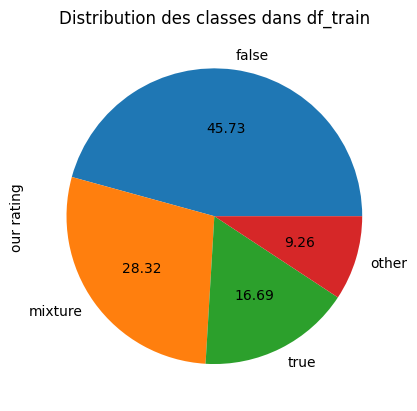

In [19]:
df_train['our rating'].value_counts().plot.pie(autopct='%.2f').set_title("Distribution des classes dans df_train")

Text(0.5, 1.0, 'Distribution des classes dans df_test')

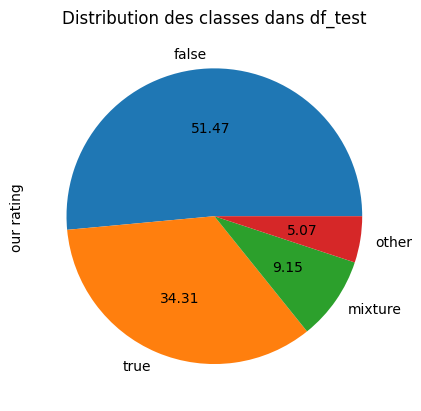

In [20]:
df_test['our rating'].value_counts().plot.pie(autopct='%.2f').set_title("Distribution des classes dans df_test")

*Vérifier s'il y'a des valeurs manquantes dans les dataframes*

In [24]:
df_train.isnull().sum()  # 23 valeurs manquantes dans le titre

public_id      0
text           0
title         23
our rating     0
dtype: int64

<Axes: >

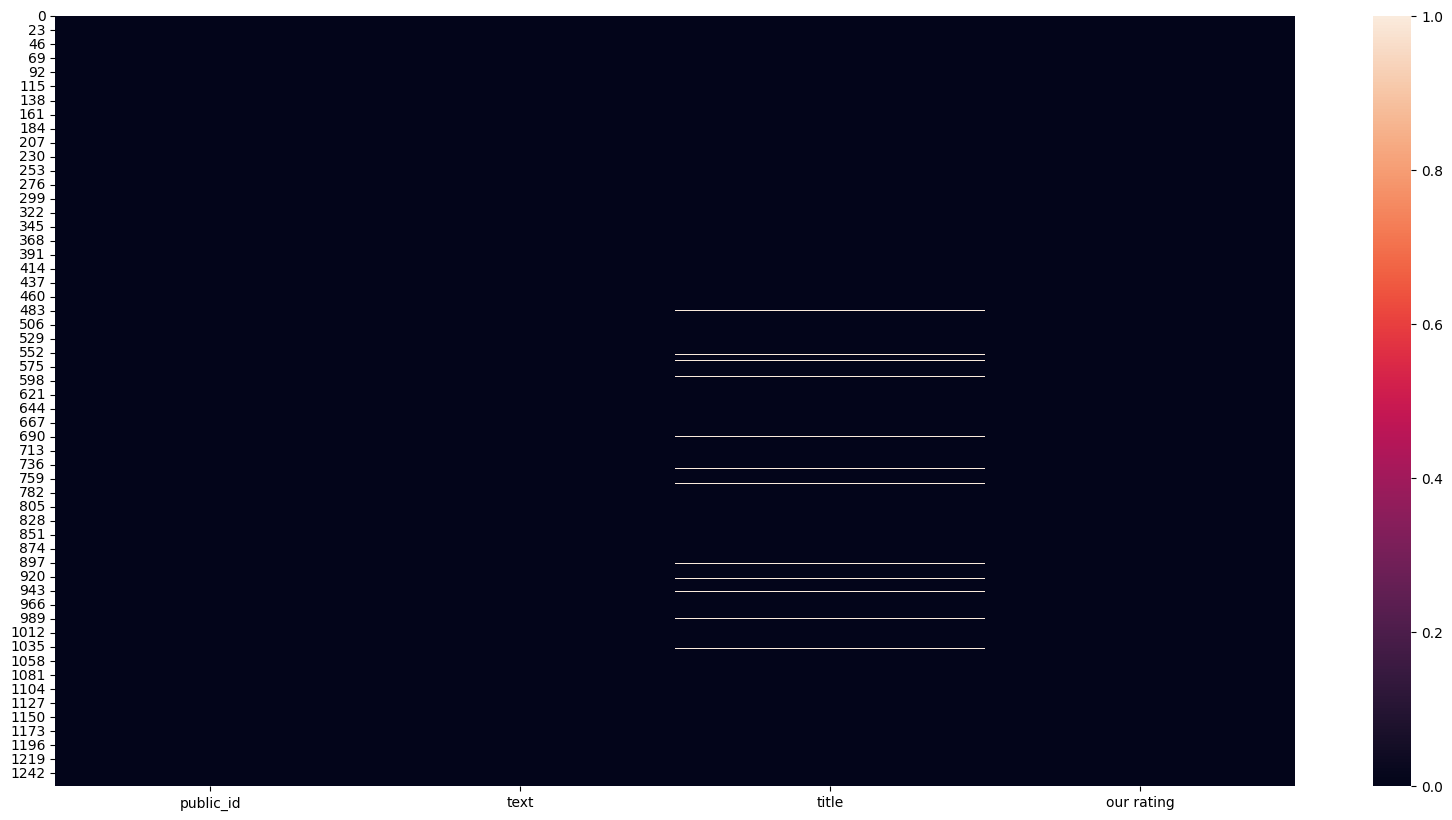

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train.isnull())

In [12]:
df_test.isnull().sum()

ID            0
text          0
title         0
our rating    0
dtype: int64

*Vérifier s'il y'a des valeurs dupliquées dans les dataframes*

In [23]:
df_train.duplicated().sum()  # 149 valeurs dupliquées

149

In [15]:
df_train.drop(columns='our rating').duplicated().sum()

149

In [14]:
df_test.duplicated().sum()

0

Vérification du type de données dans nos dataframes 

In [25]:
df_train.dtypes

public_id     object
text          object
title         object
our rating    object
dtype: object

In [26]:
df_test.dtypes

ID            object
text          object
title         object
our rating    object
dtype: object

> **3- PRE-TRAITEMENTS ET NETTOYAGE**

**Suppression des valeurs dupliquées**

In [27]:
df_train = df_train.drop_duplicates()

In [28]:
df_train.shape

(1115, 4)

**Fusion et  renommage des colonnes différentes**

*Renommage de la colonne ID de df_test*

In [29]:
df_test = df_test.rename(columns={'ID': 'public_id'})

*Fusion des deux dataframes en une seule*

In [30]:
df = pd.concat([df_train, df_test], axis=0)

In [32]:
df.shape

(1727, 4)

Text(0.5, 1.0, 'Distribution des classes')

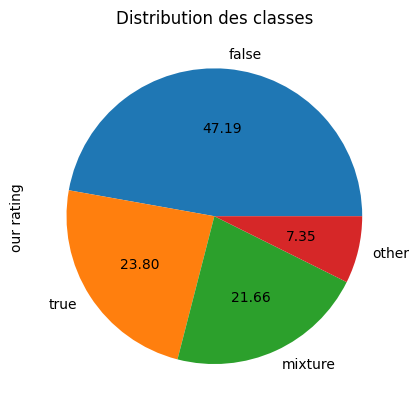

In [33]:
df['our rating'].value_counts().plot.pie(autopct='%.2f').set_title("Distribution des classes")

*Remplacer les valeurs manquantes par une chaîne vide*

In [34]:
df = df.fillna('')

In [36]:
df.isnull().sum()  # il n'y aplus de valeurs manquantes

public_id     0
text          0
title         0
our rating    0
dtype: int64

*Concaténation du titre et le texte en créant une nouvelle colonne nommée 'content'*

In [37]:
df['content'] = df['title']+ " "+ df['text']

In [38]:
df.head()

,public_id,text,title,our rating,content
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",false,"You Can Be Fined $1,500 If Your Passenger Is U..."
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,mixture,Missouri lawmakers condemn Las Vegas shooting ...
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,mixture,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,false,Obama’s Daughters Caught on Camera Burning US ...
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,false,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...


*Fonction qui effectue quelques prétraitements sur le dataframe*

In [39]:
port_stem = PorterStemmer()
def racination(content):

    ## expression régulière pour avoir tous les mots de l'alphabet (minuscules et majuscules)
    ## tout le reste sera remplacer par une chaîne vide (ex: les nombres, les ponctuations, ...)
    stemmed_content = re.sub('[^a-zA-Z]',' ', content)

    ## suppression de tous les caractères uniques
    stemmed_content = re.sub(r'\s+[a-zA-Z]\s+', ' ', stemmed_content)

    ## substitution des espaces multiples par un seul espace
    stemmed_content = re.sub(r'\s+', ' ', stemmed_content, flags=re.I)

    ## mettre tout le contenu en minuscule 
    stemmed_content = stemmed_content.lower()

    ## découpage en mots 
    stemmed_content = stemmed_content.split()

    ## racination de tous les mots excepté ceux contenu dans stop_words
    stemmed_content = [port_stem.stem(word) for word in stemmed_content  if not word in stopwords.words('english')]
    
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

*On applique notre fonction racination à X*

In [70]:
df['content'] = df['content'].apply(racination)
df['content']

0      fine passeng use mobil phone start next week d...
1      missouri lawmak condemn la vega shoot missouri...
2      cbc cut donald trump home alon cameo broadcast...
3      obama daughter caught camera burn us flag dc p...
4      leak visitor log reveal schiff visit epstein i...
                             ...                        
607    octob covid pass vaccin abolish entir territor...
608    bill gate former doctor say refus vaccin child...
609    quebec expans covid vaccin passport liquor pot...
610    alert luc montagni say vaccin would kill peopl...
611    quebec cannabi liquor store requir coronaviru ...
Name: content, Length: 1727, dtype: object

**Topic modelling**

In [43]:
import gensim 
from gensim.models.ldamulticore import  LdaMulticore
from gensim import corpora, models

In [44]:
## tokenisation de la colonne content
tokenized_docs = [nltk.word_tokenize(doc) for doc in df['content']]

## creation d'un dictionnaire pour le contenu pour trouver tous les mots uniques dans le texte 
dico = corpora.Dictionary(tokenized_docs)

In [45]:
doc_term_matrix = [dico.doc2bow(doc) for doc in  tokenized_docs]

In [46]:
lda = gensim.models.ldamodel.LdaModel

In [47]:
num_topics = 10
%time ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word = dico, passes=50, minimum_probability=0)

CPU times: user 4min 52s, sys: 2min 4s, total: 6min 56s
Wall time: 4min 58s


In [49]:
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.014*"climat" + 0.012*"chang" + 0.010*"warm" + 0.010*"year" + 0.009*"temperatur" + 0.008*"ice" + 0.008*"global" + 0.006*"sea" + 0.006*"studi" + 0.005*"scientist"'),
 (1,
  '0.013*"elect" + 0.012*"state" + 0.011*"vote" + 0.010*"ballot" + 0.008*"said" + 0.006*"would" + 0.006*"counti" + 0.006*"eu" + 0.005*"voter" + 0.004*"tax"'),
 (2,
  '0.014*"uk" + 0.014*"pictur" + 0.013*"news" + 0.010*"march" + 0.007*"pa" + 0.006*"email" + 0.006*"getti" + 0.006*"may" + 0.006*"london" + 0.005*"verifyerror"'),
 (3,
  '0.013*"fatal" + 0.012*"fire" + 0.012*"recov" + 0.011*"disord" + 0.009*"incl" + 0.007*"includ" + 0.007*"russian" + 0.006*"forest" + 0.006*"system" + 0.006*"report"'),
 (4,
  '0.007*"uk" + 0.006*"countri" + 0.006*"trade" + 0.006*"govern" + 0.006*"us" + 0.006*"state" + 0.005*"export" + 0.005*"report" + 0.004*"right" + 0.004*"new"'),
 (5,
  '0.010*"said" + 0.008*"court" + 0.007*"law" + 0.006*"state" + 0.006*"bill" + 0.006*"clinton" + 0.006*"year" + 0.005*"women" + 0.005*"senat" + 0.005

In [50]:
for i, topic in ldamodel.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"Topic {i+1}:")
    for word, prob in topic:
        print(f"\t{word}: {prob}")
         

Topic 1:
	climat: 0.014181493781507015
	chang: 0.012075013481080532
	warm: 0.010006148368120193
	year: 0.009741618297994137
	temperatur: 0.00877748429775238
	ice: 0.007696999702602625
	global: 0.007554222363978624
	sea: 0.00586968706920743
	studi: 0.0057697114534676075
	scientist: 0.005417780019342899
Topic 2:
	elect: 0.012511832639575005
	state: 0.011620617471635342
	vote: 0.011068281717598438
	ballot: 0.009540996514260769
	said: 0.00811038352549076
	would: 0.006017868872731924
	counti: 0.0057274578139185905
	eu: 0.005657677073031664
	voter: 0.005348768085241318
	tax: 0.004204831551760435
Topic 3:
	uk: 0.013821769505739212
	pictur: 0.013560098595917225
	news: 0.013389518484473228
	march: 0.00961542408913374
	pa: 0.006655572913587093
	email: 0.006258699111640453
	getti: 0.006183168850839138
	may: 0.005896247923374176
	london: 0.005885935388505459
	verifyerror: 0.00548726599663496
Topic 4:
	fatal: 0.01266663707792759
	fire: 0.012185655534267426
	recov: 0.011812313459813595
	disord: 0.01

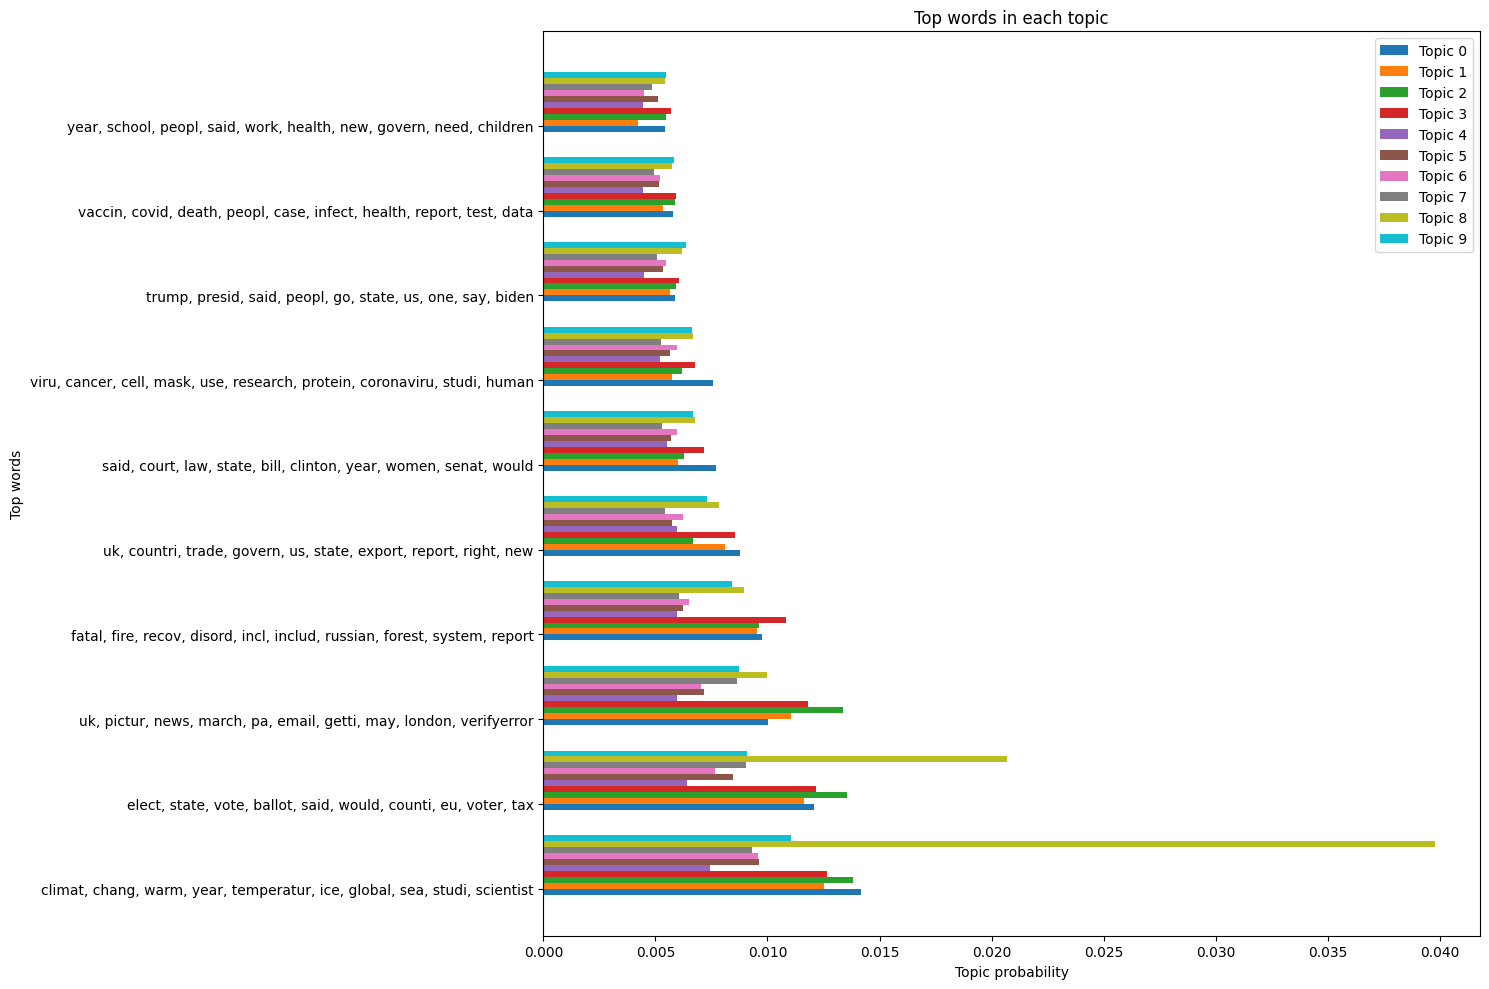

In [57]:
#  visualisation des mots les plus fréquents dans chaque topic
top_words_per_topic = []
for i in range(num_topics):
    top_words = [word for word, _ in ldamodel.show_topic(i, topn=10)]
    top_words_per_topic.append(', '.join(top_words))

# Get the probabilities for each top word
topic_word_probs = np.zeros((num_topics, 10))
for i in range(num_topics):
    for j, (_, prob) in enumerate(ldamodel.show_topic(i, topn=10)):
        topic_word_probs[i, j] = prob

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(10)
bar_width = 0.7 / num_topics
opacity = 1

for i in range(num_topics):
    ax.barh(index + i*bar_width, topic_word_probs[i], bar_width,
            alpha=opacity, label='Topic {}'.format(i))

ax.set_xlabel('Topic probability')
ax.set_ylabel('Top words')
ax.set_title('Top words in each topic')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(top_words_per_topic)
ax.legend()

plt.tight_layout()
plt.show()



In [58]:
#### recherche des articles arpartenant à un topic spécifique définit par notre model LDA

lda_corpus = ldamodel[doc_term_matrix]

### recuprération des probabilités de chaque topic pour chaque article
[doc for doc in lda_corpus]


[[(0, 0.00077994016),
  (1, 0.0007799392),
  (2, 0.00077992084),
  (3, 0.0007800139),
  (4, 0.12169903),
  (5, 0.11949298),
  (6, 0.26655826),
  (7, 0.43359414),
  (8, 0.054755703),
  (9, 0.0007800432)],
 [(0, 0.0002232124),
  (1, 0.00022321746),
  (2, 0.00022320171),
  (3, 0.00022318687),
  (4, 0.00022321033),
  (5, 0.16304588),
  (6, 0.00022319937),
  (7, 0.8351685),
  (8, 0.00022320355),
  (9, 0.000223204)],
 [(0, 0.00039598966),
  (1, 0.00039602842),
  (2, 0.3350579),
  (3, 0.00039596518),
  (4, 0.0003960305),
  (5, 0.00039600075),
  (6, 0.00039598742),
  (7, 0.66177404),
  (8, 0.00039601995),
  (9, 0.00039602566)],
 [(0, 0.0006033136),
  (1, 0.0006032494),
  (2, 0.0006032763),
  (3, 0.0006032561),
  (4, 0.0006032567),
  (5, 0.00060332136),
  (6, 0.0006032777),
  (7, 0.99457043),
  (8, 0.00060325454),
  (9, 0.000603387)],
 [(0, 0.060137916),
  (1, 0.0006219173),
  (2, 0.0006219285),
  (3, 0.0006218858),
  (4, 0.00062203256),
  (5, 0.00062193605),
  (6, 0.00062191195),
  (7, 0.91100

**Séparation des données à prédire**

In [71]:
X = df.drop(columns='our rating', axis=1)
Y = df['our rating']

> **4- Tâches de classification**

*Création d'un masque pour la classification  des classes True et false* **LOUM**

<ipython-input-72-0e559a176a4c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_false_label['our rating'] = true_false_label['our rating'].replace({'false': 0, 'true': 1})


Text(0.5, 1.0, 'Distribution des classes {true} vs {false}')

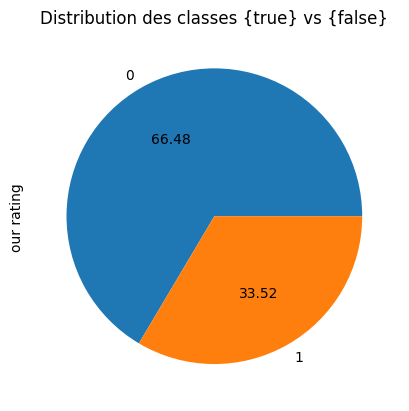

In [72]:

# Créer un masque booléen pour filtrer les valeurs True et False de la colonne 'our rating'
mask = Y.isin(['true', 'false'])
true_false_label= df[mask]

true_false_label['our rating'] = true_false_label['our rating'].replace({'false': 0, 'true': 1})
# Créer un graphique pour visualiser les valeurs filtrées
true_false_label['our rating'].value_counts().plot.pie(autopct='%.2f').set_title("Distribution des classes {true} vs {false}")



*Création d'un masque pour la classification  des classes True et false et other* **MAGUETTE**

<ipython-input-73-a73a5fe7e2c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_false_other_label['our rating'] = true_false_other_label['our rating'].replace({'false': 1, 'true': 1, 'other':0})


Text(0.5, 1.0, 'Distribution des classes {true,false} vs {other}')

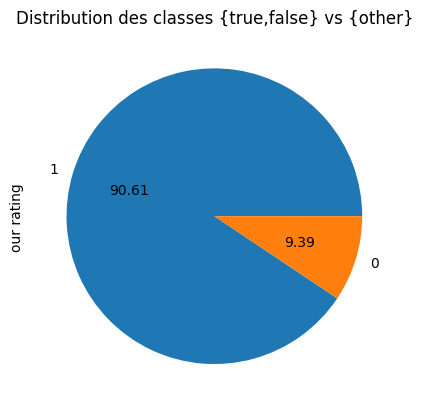

In [73]:
mask2 = Y.isin(['true', 'false', 'other'])
true_false_other_label= df[mask2]

true_false_other_label['our rating'] = true_false_other_label['our rating'].replace({'false': 1, 'true': 1, 'other':0})
# Créer un graphique pour visualiser les valeurs filtrées
true_false_other_label['our rating'].value_counts().plot.pie(autopct='%.2f').set_title("Distribution des classes {true,false} vs {other}")


Création d'un masque pour la classification  des classes True, false, other and mixture* ***KARIM FATIMA(rapport) ET SOUHAILA**

Text(0.5, 1.0, 'Distribution des classes')

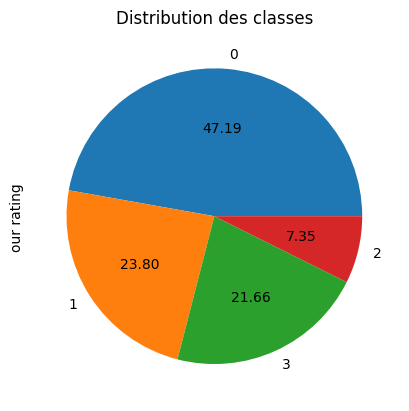

In [74]:
mask3 = Y.isin(['true', 'false', 'other', 'mixture'])
true_false_other_mixture_label= df[mask3]
true_false_other_mixture_label['our rating'] = true_false_other_mixture_label['our rating'].replace({'false': 0, 'true': 1, 'other':2, 'mixture':3})
# Créer un graphique pour visualiser les valeurs filtrées
true_false_other_mixture_label['our rating'].value_counts().plot.pie(autopct='%.2f').set_title("Distribution des classes")

#### **Assigner à une valeur à Y en fonction de la classification à effectuer**

In [75]:
y = true_false_label['our rating'] ### classification true_false

In [76]:
y1 = true_false_other_label['our rating'] ### classification true_false_other

In [77]:
y2 = true_false_other_mixture_label['our rating'] ### classification true_false_other_mixture

**Sélection des contenus associés à ces contenus**

  *- contenus des articles vrais et faux*

In [78]:
true_false_filtered_content = true_false_label['content']

In [79]:
true_false_filtered_content

0      fine passeng use mobil phone start next week d...
3      obama daughter caught camera burn us flag dc p...
4      leak visitor log reveal schiff visit epstein i...
6      fda shock studi cell use vaccin contamin serio...
7      israel hit beirut nuclear missil trump lebanes...
                             ...                        
606    quebec liquor cannabi store requir vaccin pass...
607    octob covid pass vaccin abolish entir territor...
609    quebec expans covid vaccin passport liquor pot...
610    alert luc montagni say vaccin would kill peopl...
611    quebec cannabi liquor store requir coronaviru ...
Name: content, Length: 1226, dtype: object

  *- contenus des articles vrais, faux et other*

In [80]:
 true_false_other_filtered_content = true_false_other_label['content']

In [81]:
true_false_other_filtered_content

0      fine passeng use mobil phone start next week d...
3      obama daughter caught camera burn us flag dc p...
4      leak visitor log reveal schiff visit epstein i...
5      k b governor secretari state georgia took mone...
6      fda shock studi cell use vaccin contamin serio...
                             ...                        
607    octob covid pass vaccin abolish entir territor...
608    bill gate former doctor say refus vaccin child...
609    quebec expans covid vaccin passport liquor pot...
610    alert luc montagni say vaccin would kill peopl...
611    quebec cannabi liquor store requir coronaviru ...
Name: content, Length: 1353, dtype: object

  *- tous le contenu de notre dataset*

In [82]:
allFiltered_content= df['content']

In [83]:
allFiltered_content

0      fine passeng use mobil phone start next week d...
1      missouri lawmak condemn la vega shoot missouri...
2      cbc cut donald trump home alon cameo broadcast...
3      obama daughter caught camera burn us flag dc p...
4      leak visitor log reveal schiff visit epstein i...
                             ...                        
607    octob covid pass vaccin abolish entir territor...
608    bill gate former doctor say refus vaccin child...
609    quebec expans covid vaccin passport liquor pot...
610    alert luc montagni say vaccin would kill peopl...
611    quebec cannabi liquor store requir coronaviru ...
Name: content, Length: 1727, dtype: object

**Assignation de X à un contenu pour pour faire l'apprentissage automatique sur le contenu**

In [84]:
X0 = true_false_filtered_content

In [86]:
X1 =  true_false_other_filtered_content

In [87]:
X2 = allFiltered_content



>**5- VECTORISATION: Convertir les données textuelles en données numériques**

2 approches:
- Bag of words (BOW) avec 'CountVectorizer'
- 'TF_IDF' 

 

**On choisit TF-IDF**

In [88]:
vectorizer = TfidfVectorizer()
## appliquer la vectorisation sur le contenu du jeu d'entrainement et du jeu de test
X0 = vectorizer.fit_transform(X0)

In [89]:
X1= vectorizer.fit_transform(X1)

In [90]:
X2 = vectorizer.fit_transform(X2)

**Création d'un jeu d'apprentissage et de test**

In [96]:
X0_train, X0_test, y_train, y_test = train_test_split(X0, y, test_size=0.2, random_state=7)

In [97]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=7)

In [98]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=7)

**Création du tableau  des différents classifieurs**

In [103]:
models=[]
models.append(('MultinomialNB',MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB',GradientBoostingClassifier()))
models.append(('SVM', SVC()))

In [100]:
# fonctions utilities (affichage, confusion, etc.)
from MyNLPUtilities import *

**Evaluation des  modeles**

**Mon test de modeles sur les true & false**

Evaluation de  MultinomialNB
MultinomialNB : 0.684 (0.046) in 0.072 s
Evaluation de  LR
LR : 0.721 (0.041) in 3.636 s
Evaluation de  KNN
KNN : 0.699 (0.038) in 51.590 s
Evaluation de  CART
CART : 0.665 (0.039) in 5.110 s
Evaluation de  RF
RF : 0.733 (0.051) in 11.921 s
Evaluation de  GB
GB : 0.723 (0.047) in 101.659 s
Evaluation de  SVM
SVM : 0.737 (0.043) in 20.434 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.737  (0.043)  en 20.434   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.737  (0.043)  en 20.434   s
Classifier :  RF  accuracy : 0.733  (0.051)  en 11.921   s
Classifier :  GB  accuracy : 0.723  (0.047)  en 101.659   s
Classifier :  LR  accuracy : 0.721  (0.041)  en 3.636   s
Classifier :  KNN  accuracy : 0.699  (0.038)  en 51.590   s
Classifier :  MultinomialNB  accuracy : 0.684  (0.046)  en 0.072   s
Classifier :  CART  accuracy : 0.665  (0.039)  en 5.110   s


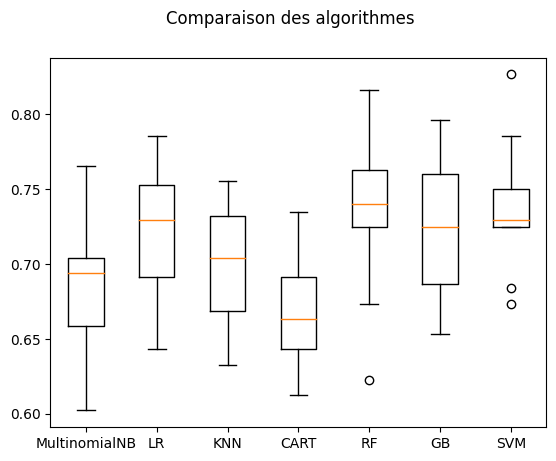

In [104]:
MyTestPipelines(models,X0_train,y_train,'accuracy')

In [142]:
model = SVC()

Accuracy : 0.756
Classification Report
              precision    recall  f1-score   support

           0    0.74163   0.96273   0.83784       161
           1    0.83784   0.36471   0.50820        85

    accuracy                        0.75610       246
   macro avg    0.78973   0.66372   0.67302       246
weighted avg    0.77487   0.75610   0.72394       246



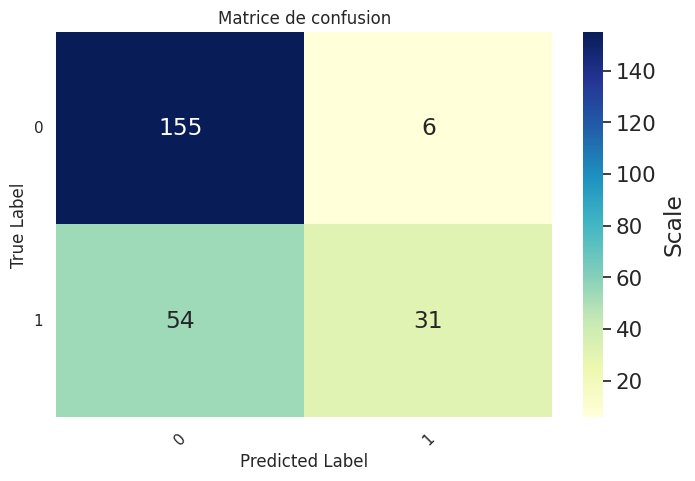

In [143]:
model.fit(X0_train, y_train)
y_pred = model.predict(X0_test)
MyshowAllScores(y_test,y_pred)

# Ce modèle est plus capable de prédire la classe 0 que la classe 1

**Mon test de modeles sur les true, false et other**

Evaluation de  MultinomialNB
MultinomialNB : 0.914 (0.029) in 0.072 s
Evaluation de  LR
LR : 0.914 (0.029) in 2.336 s
Evaluation de  KNN
KNN : 0.911 (0.028) in 52.956 s
Evaluation de  CART
CART : 0.859 (0.035) in 9.741 s
Evaluation de  RF
RF : 0.916 (0.028) in 21.647 s
Evaluation de  GB
GB : 0.907 (0.029) in 144.657 s
Evaluation de  SVM
SVM : 0.914 (0.029) in 23.055 s

Le meilleur resultat : 
Classifier :  RF  accuracy : 0.916  (0.028)  en 21.647   s

Tous les résultats : 

Classifier :  RF  accuracy : 0.916  (0.028)  en 21.647   s
Classifier :  MultinomialNB  accuracy : 0.914  (0.029)  en 0.072   s
Classifier :  LR  accuracy : 0.914  (0.029)  en 2.336   s
Classifier :  SVM  accuracy : 0.914  (0.029)  en 23.055   s
Classifier :  KNN  accuracy : 0.911  (0.028)  en 52.956   s
Classifier :  GB  accuracy : 0.907  (0.029)  en 144.657   s
Classifier :  CART  accuracy : 0.859  (0.035)  en 9.741   s


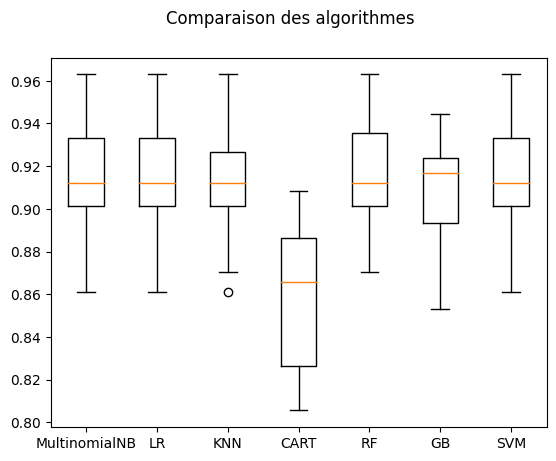

In [105]:
MyTestPipelines(models,X1_train,y1_train,'accuracy')

In [144]:
model1=RandomForestClassifier()

Accuracy : 0.875
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        34
           1    0.87454   1.00000   0.93307       237

    accuracy                        0.87454       271
   macro avg    0.43727   0.50000   0.46654       271
weighted avg    0.76482   0.87454   0.81601       271



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


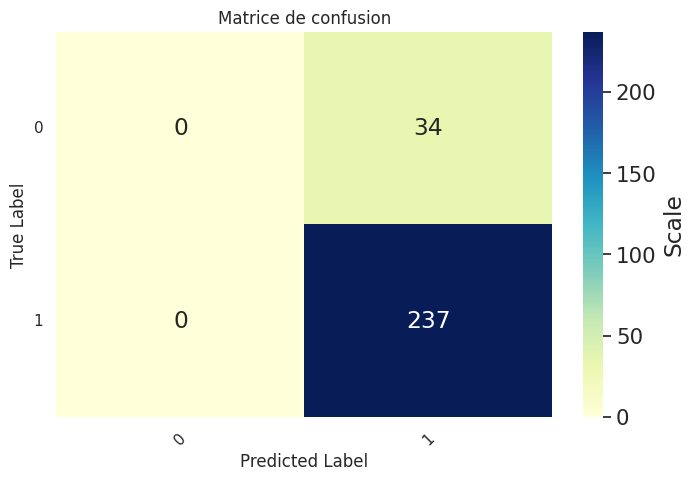

In [148]:
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)
MyshowAllScores(y1_test,y1_pred)

# ce modèle est icapable de prédire la classe 0
# Remaquons le f1-score de la classe 0 est nul comparé à la classe 1 (c'est pas bien)

**Mon test de modeles sur les true, false, other et mixture**

Evaluation de  MultinomialNB
MultinomialNB : 0.468 (0.021) in 0.093 s
Evaluation de  LR
LR : 0.555 (0.024) in 40.579 s
Evaluation de  KNN
KNN : 0.503 (0.027) in 101.736 s
Evaluation de  CART
CART : 0.444 (0.042) in 19.451 s
Evaluation de  RF
RF : 0.543 (0.021) in 30.423 s
Evaluation de  GB
GB : 0.533 (0.027) in 688.349 s
Evaluation de  SVM
SVM : 0.547 (0.020) in 80.045 s

Le meilleur resultat : 
Classifier :  LR  accuracy : 0.555  (0.024)  en 40.579   s

Tous les résultats : 

Classifier :  LR  accuracy : 0.555  (0.024)  en 40.579   s
Classifier :  SVM  accuracy : 0.547  (0.020)  en 80.045   s
Classifier :  RF  accuracy : 0.543  (0.021)  en 30.423   s
Classifier :  GB  accuracy : 0.533  (0.027)  en 688.349   s
Classifier :  KNN  accuracy : 0.503  (0.027)  en 101.736   s
Classifier :  MultinomialNB  accuracy : 0.468  (0.021)  en 0.093   s
Classifier :  CART  accuracy : 0.444  (0.042)  en 19.451   s


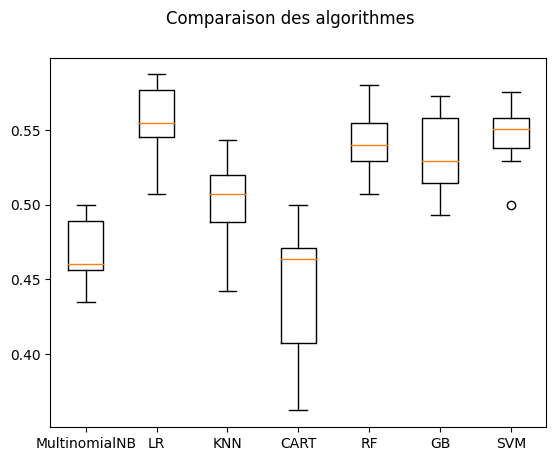

In [106]:
MyTestPipelines(models,X2_train,y2_train,'accuracy')

In [146]:
model2=LogisticRegression(solver='lbfgs')

Accuracy : 0.578
Classification Report
              precision    recall  f1-score   support

           0    0.61943   0.86932   0.72340       176
           1    0.54717   0.37179   0.44275        78
           2    0.00000   0.00000   0.00000        25
           3    0.39130   0.26866   0.31858        67

    accuracy                        0.57803       346
   macro avg    0.38948   0.37744   0.37118       346
weighted avg    0.51421   0.57803   0.52948       346



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


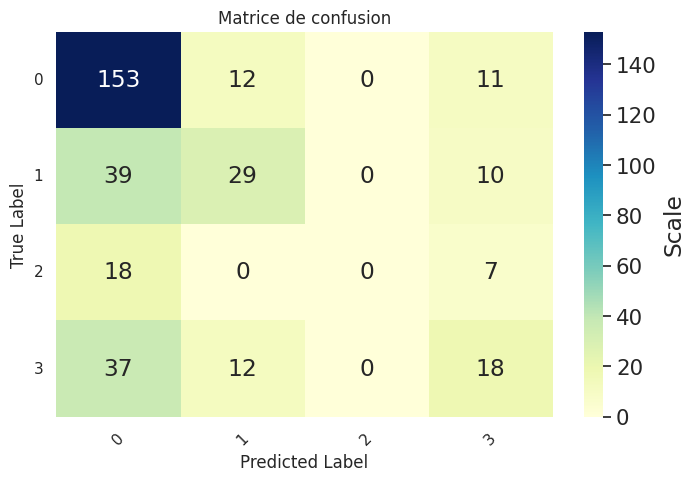

In [149]:
model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)
MyshowAllScores(y2_test,y2_pred)

# Ce modèle est icapable de prédire la classe
# Remaquons le f1-score de la classe 2 est nul comparé aux autres classes (c'est pas bien)

>**-6 EQUILIBRAGE  DES DONNEES D'APPRENTISSAGE**

* **Random Undersampling: Sur-échantillonnage aléatoire**

In [107]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='not minority')

**RUS des true et false**

In [108]:
X0_train.shape, X0_test.shape, y_train.shape, y_test.shape

((980, 22053), (246, 22053), (980,), (246,))

In [110]:
y_train.value_counts()   #la claase 0 est majoritaire
                            # et la classe 1, minoritaire

0    654
1    326
Name: our rating, dtype: int64

In [111]:
X0_equi_rus, y_equi_rus= rus.fit_resample(X0_train, y_train)

Text(0.5, 1.0, 'Sous-échantillonnage de la classe majotitaire')

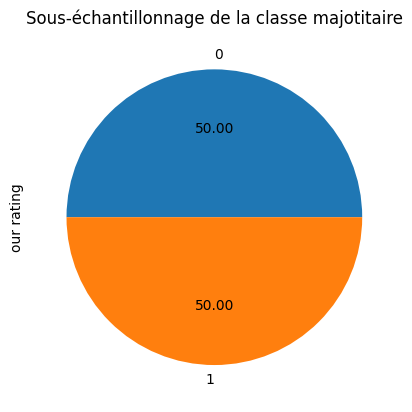

In [112]:
###visualisation des equilibrage  des true et false 
y_equi_rus.value_counts().plot.pie(autopct='%.2f').set_title("Sous-échantillonnage de la classe majotitaire")

In [113]:
y_equi_rus.value_counts()

0    326
1    326
Name: our rating, dtype: int64

**RUS des true, false et other**

In [114]:
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((1082, 22983), (271, 22983), (1082,), (271,))

In [115]:
y1_train.value_counts()   #la claase 1 est majoritaire
                            # et la classe 0, minoritaire

1    989
0     93
Name: our rating, dtype: int64

In [116]:
X1_equi_rus, y1_equi_rus= rus.fit_resample(X1_train, y1_train)

Text(0.5, 1.0, 'Sous-échantillonnage de la classe majotitaire')

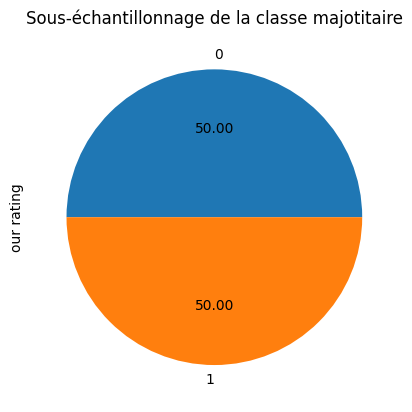

In [117]:
###visualisation des equilibrage  des true, false et other
y1_equi_rus.value_counts().plot.pie(autopct='%.2f').set_title("Sous-échantillonnage de la classe majotitaire")

In [118]:
y1_equi_rus.value_counts()

0    93
1    93
Name: our rating, dtype: int64

**RUS des all labels**

In [119]:
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((1381, 25706), (346, 25706), (1381,), (346,))

In [120]:
y2_train.value_counts()   #la claase 0 est majoritaire
                            # et la classe 2, minoritaire

0    639
1    333
3    307
2    102
Name: our rating, dtype: int64

In [123]:
X2_equi_rus, y2_equi_rus= rus.fit_resample(X2_train, y2_train)

Text(0.5, 1.0, 'Sous-échantillonnage de la classe majotitaire')

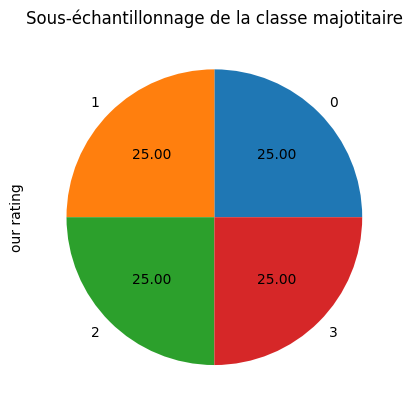

In [124]:
###visualisation des equilibrage  des true, false et other
y2_equi_rus.value_counts().plot.pie(autopct='%.2f').set_title("Sous-échantillonnage de la classe majotitaire")

In [125]:
y2_equi_rus.value_counts()

0    102
1    102
2    102
3    102
Name: our rating, dtype: int64

**Evaluation avec les données équilibrées par RUS**

Evaluation de  MultinomialNB
MultinomialNB : 0.718 (0.048) in 0.066 s
Evaluation de  LR
LR : 0.748 (0.055) in 2.503 s
Evaluation de  KNN
KNN : 0.652 (0.073) in 28.927 s
Evaluation de  CART
CART : 0.590 (0.058) in 5.961 s
Evaluation de  RF
RF : 0.725 (0.056) in 15.122 s
Evaluation de  GB
GB : 0.715 (0.046) in 96.836 s
Evaluation de  SVM
SVM : 0.750 (0.050) in 10.470 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.750  (0.050)  en 10.470   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.750  (0.050)  en 10.470   s
Classifier :  LR  accuracy : 0.748  (0.055)  en 2.503   s
Classifier :  RF  accuracy : 0.725  (0.056)  en 15.122   s
Classifier :  MultinomialNB  accuracy : 0.718  (0.048)  en 0.066   s
Classifier :  GB  accuracy : 0.715  (0.046)  en 96.836   s
Classifier :  KNN  accuracy : 0.652  (0.073)  en 28.927   s
Classifier :  CART  accuracy : 0.590  (0.058)  en 5.961   s


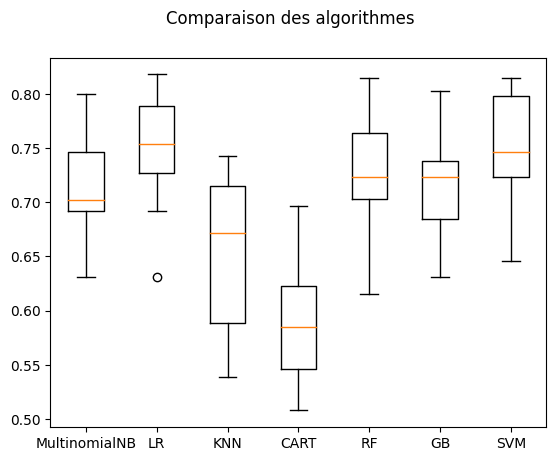

In [126]:
MyTestPipelines(models,X0_equi_rus,y_equi_rus,'accuracy')

Accuracy : 0.768
Classification Report
              precision    recall  f1-score   support

           0    0.88806   0.73913   0.80678       161
           1    0.62500   0.82353   0.71066        85

    accuracy                        0.76829       246
   macro avg    0.75653   0.78133   0.75872       246
weighted avg    0.79717   0.76829   0.77357       246



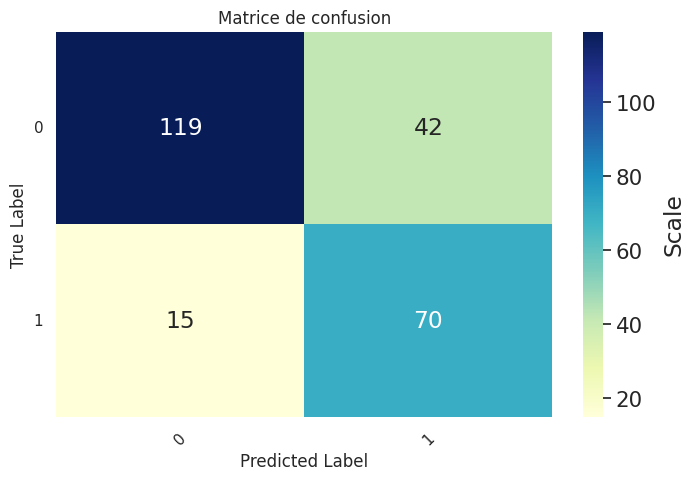

In [150]:
model.fit(X0_equi_rus, y_equi_rus)
y_pred_rus = model.predict(X0_test)
MyshowAllScores(y_test,y_pred_rus)

Evaluation de  MultinomialNB
MultinomialNB : 0.536 (0.123) in 0.255 s
Evaluation de  LR
LR : 0.567 (0.142) in 2.096 s
Evaluation de  KNN
KNN : 0.548 (0.108) in 1.339 s
Evaluation de  CART
CART : 0.591 (0.117) in 0.555 s
Evaluation de  RF
RF : 0.590 (0.080) in 3.706 s
Evaluation de  GB
GB : 0.613 (0.064) in 31.954 s
Evaluation de  SVM
SVM : 0.536 (0.152) in 1.006 s

Le meilleur resultat : 
Classifier :  GB  accuracy : 0.613  (0.064)  en 31.954   s

Tous les résultats : 

Classifier :  GB  accuracy : 0.613  (0.064)  en 31.954   s
Classifier :  CART  accuracy : 0.591  (0.117)  en 0.555   s
Classifier :  RF  accuracy : 0.590  (0.080)  en 3.706   s
Classifier :  LR  accuracy : 0.567  (0.142)  en 2.096   s
Classifier :  KNN  accuracy : 0.548  (0.108)  en 1.339   s
Classifier :  MultinomialNB  accuracy : 0.536  (0.123)  en 0.255   s
Classifier :  SVM  accuracy : 0.536  (0.152)  en 1.006   s


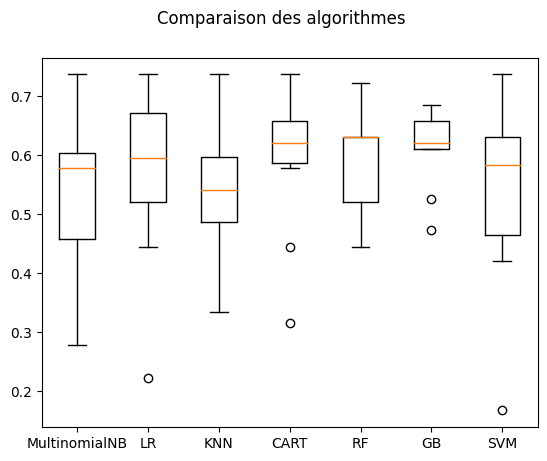

In [127]:
MyTestPipelines(models,X1_equi_rus,y1_equi_rus,'accuracy')

In [151]:
model1_rus=GradientBoostingClassifier()

Accuracy : 0.875
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        34
           1    0.87454   1.00000   0.93307       237

    accuracy                        0.87454       271
   macro avg    0.43727   0.50000   0.46654       271
weighted avg    0.76482   0.87454   0.81601       271



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


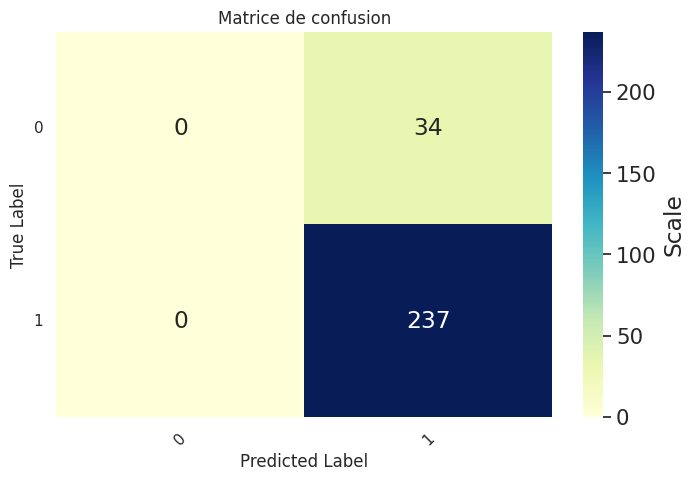

In [153]:
model1_rus.fit(X1_equi_rus, y1_equi_rus)
y1_pred_rus = model1.predict(X1_test)
MyshowAllScores(y1_test,y1_pred_rus)

# Remaquons le f1-score de la classe 0 est nul comparé à la classe 1 (c'est pas bien)

Evaluation de  MultinomialNB
MultinomialNB : 0.355 (0.106) in 0.066 s
Evaluation de  LR
LR : 0.409 (0.080) in 13.864 s
Evaluation de  KNN
KNN : 0.304 (0.080) in 14.119 s
Evaluation de  CART
CART : 0.311 (0.074) in 2.570 s
Evaluation de  RF
RF : 0.377 (0.067) in 13.095 s
Evaluation de  GB
GB : 0.346 (0.055) in 272.187 s
Evaluation de  SVM
SVM : 0.360 (0.077) in 5.916 s

Le meilleur resultat : 
Classifier :  LR  accuracy : 0.409  (0.080)  en 13.864   s

Tous les résultats : 

Classifier :  LR  accuracy : 0.409  (0.080)  en 13.864   s
Classifier :  RF  accuracy : 0.377  (0.067)  en 13.095   s
Classifier :  SVM  accuracy : 0.360  (0.077)  en 5.916   s
Classifier :  MultinomialNB  accuracy : 0.355  (0.106)  en 0.066   s
Classifier :  GB  accuracy : 0.346  (0.055)  en 272.187   s
Classifier :  CART  accuracy : 0.311  (0.074)  en 2.570   s
Classifier :  KNN  accuracy : 0.304  (0.080)  en 14.119   s


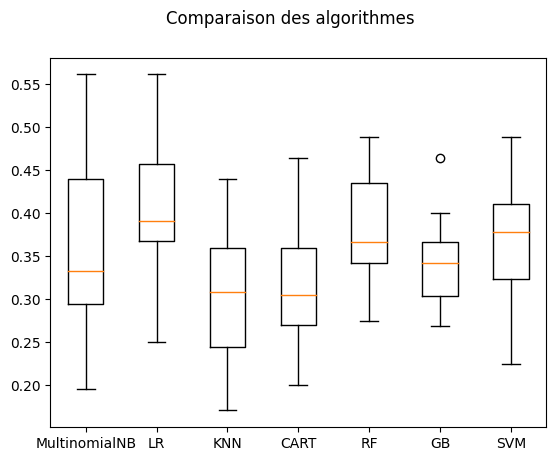

In [128]:
MyTestPipelines(models,X2_equi_rus,y2_equi_rus,'accuracy')

Accuracy : 0.460
Classification Report
              precision    recall  f1-score   support

           0    0.73770   0.51136   0.60403       176
           1    0.46154   0.30769   0.36923        78
           2    0.12903   0.32000   0.18391        25
           3    0.33636   0.55224   0.41808        67

    accuracy                        0.45954       346
   macro avg    0.41616   0.42282   0.39381       346
weighted avg    0.55375   0.45954   0.48473       346



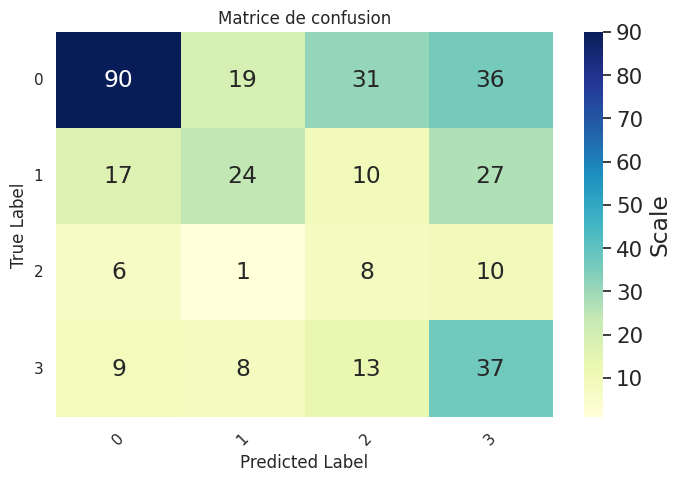

In [154]:
model2.fit(X2_equi_rus, y2_equi_rus)
y2_pred_rus = model2.predict(X2_test)
MyshowAllScores(y2_test,y2_pred_rus)

* **Random Oversampling: Sur-échantillonnage aléatoire**

In [129]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority')

**ROS des true et false**

In [130]:
X0_equi_sm, y_equi_sm= sm.fit_resample(X0_train, y_train)

Text(0.5, 1.0, 'Sur-échantillonnage de la classe minoritaire')

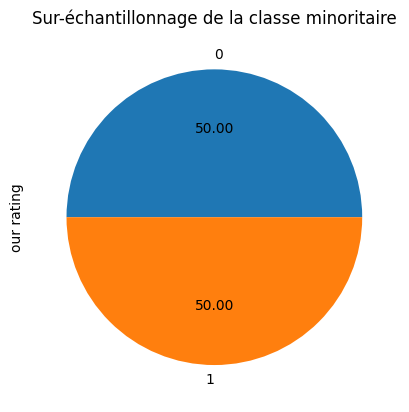

In [131]:
###visualisation des equilibrage  des true et false 
y_equi_sm.value_counts().plot.pie(autopct='%.2f').set_title("Sur-échantillonnage de la classe minoritaire")

In [132]:
y_equi_sm.value_counts()

0    654
1    654
Name: our rating, dtype: int64

**ROS des true, false et other**

In [133]:
X1_equi_sm, y1_equi_sm= sm.fit_resample(X1_train, y1_train)

Text(0.5, 1.0, 'Sur-échantillonnage de la classe minoritaire')

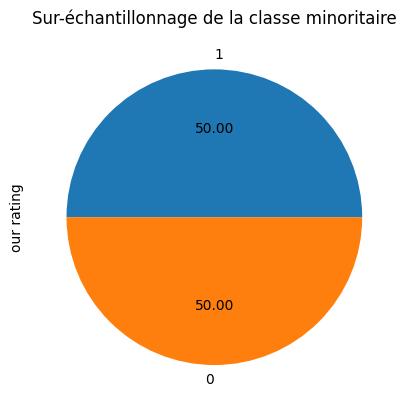

In [134]:
###visualisation des equilibrage  des true et false 
y1_equi_sm.value_counts().plot.pie(autopct='%.2f').set_title("Sur-échantillonnage de la classe minoritaire")

In [135]:
y1_equi_sm.value_counts()

1    989
0    989
Name: our rating, dtype: int64

**ROS des all label**

In [136]:
X2_equi_sm, y2_equi_sm= sm.fit_resample(X2_train, y2_train)

Text(0.5, 1.0, 'Sur-échantillonnage de la classe minoritaire')

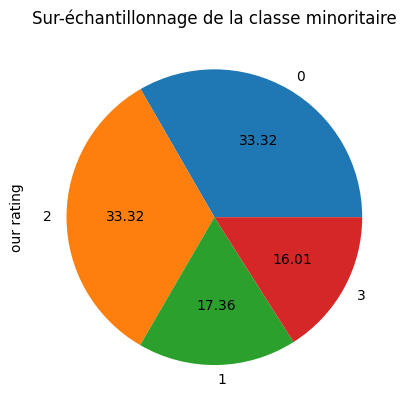

In [137]:
###visualisation des equilibrage des true et false 
y2_equi_sm.value_counts().plot.pie(autopct='%.2f').set_title("Sur-échantillonnage de la classe minoritaire")

In [138]:
y2_equi_sm.value_counts()

0    639
2    639
1    333
3    307
Name: our rating, dtype: int64

**Evaluation avec les données équilibrées par ROS**

Evaluation de  MultinomialNB
MultinomialNB : 0.769 (0.041) in 0.080 s
Evaluation de  LR
LR : 0.853 (0.026) in 2.719 s
Evaluation de  KNN
KNN : 0.563 (0.048) in 144.050 s
Evaluation de  CART
CART : 0.748 (0.037) in 7.607 s
Evaluation de  RF
RF : 0.833 (0.034) in 21.644 s
Evaluation de  GB
GB : 0.832 (0.028) in 160.472 s
Evaluation de  SVM
SVM : 0.877 (0.022) in 49.750 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.877  (0.022)  en 49.750   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.877  (0.022)  en 49.750   s
Classifier :  LR  accuracy : 0.853  (0.026)  en 2.719   s
Classifier :  RF  accuracy : 0.833  (0.034)  en 21.644   s
Classifier :  GB  accuracy : 0.832  (0.028)  en 160.472   s
Classifier :  MultinomialNB  accuracy : 0.769  (0.041)  en 0.080   s
Classifier :  CART  accuracy : 0.748  (0.037)  en 7.607   s
Classifier :  KNN  accuracy : 0.563  (0.048)  en 144.050   s


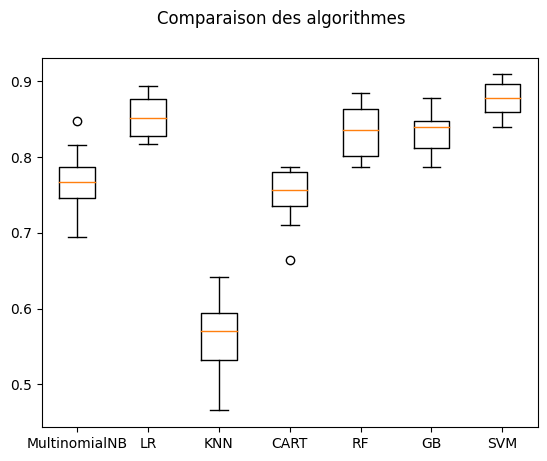

In [139]:
MyTestPipelines(models,X0_equi_sm,y_equi_sm,'accuracy')

Accuracy : 0.768
Classification Report
              precision    recall  f1-score   support

           0    0.75243   0.96273   0.84469       161
           1    0.85000   0.40000   0.54400        85

    accuracy                        0.76829       246
   macro avg    0.80121   0.68137   0.69434       246
weighted avg    0.78614   0.76829   0.74079       246



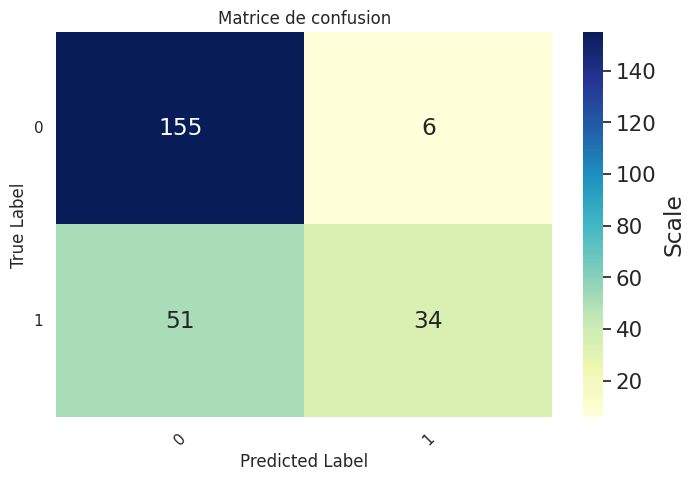

In [155]:
model.fit(X0_equi_sm, y_equi_sm)
y_pred_sm = model.predict(X0_test)
MyshowAllScores(y_test,y_pred_sm)

Evaluation de  MultinomialNB
MultinomialNB : 0.924 (0.023) in 0.141 s
Evaluation de  LR
LR : 0.974 (0.011) in 4.096 s
Evaluation de  KNN
KNN : 0.562 (0.031) in 350.942 s
Evaluation de  CART
CART : 0.911 (0.024) in 17.691 s
Evaluation de  RF
RF : 0.985 (0.010) in 18.114 s
Evaluation de  GB
GB : 0.970 (0.008) in 287.210 s
Evaluation de  SVM
SVM : 0.996 (0.005) in 89.479 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.996  (0.005)  en 89.479   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.996  (0.005)  en 89.479   s
Classifier :  RF  accuracy : 0.985  (0.010)  en 18.114   s
Classifier :  LR  accuracy : 0.974  (0.011)  en 4.096   s
Classifier :  GB  accuracy : 0.970  (0.008)  en 287.210   s
Classifier :  MultinomialNB  accuracy : 0.924  (0.023)  en 0.141   s
Classifier :  CART  accuracy : 0.911  (0.024)  en 17.691   s
Classifier :  KNN  accuracy : 0.562  (0.031)  en 350.942   s


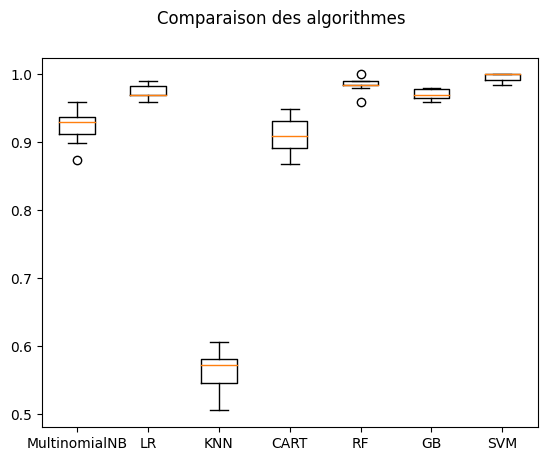

In [140]:
MyTestPipelines(models,X1_equi_sm,y1_equi_sm,'accuracy')

Accuracy : 0.867
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        34
           1    0.87361   0.99156   0.92885       237

    accuracy                        0.86716       271
   macro avg    0.43680   0.49578   0.46443       271
weighted avg    0.76400   0.86716   0.81232       271



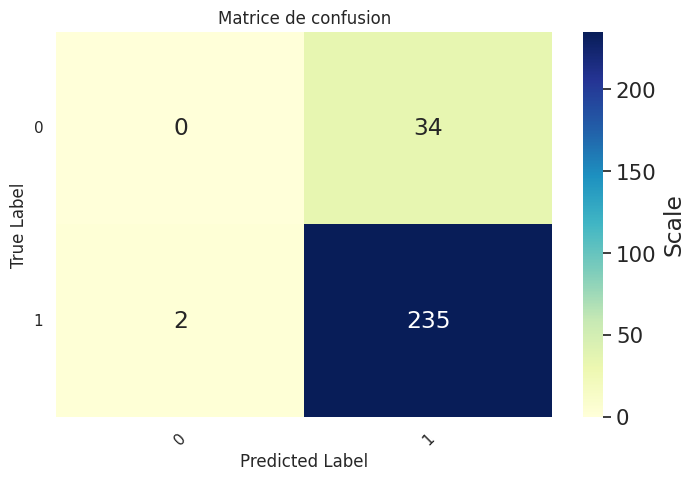

In [159]:
model.fit(X1_equi_sm, y1_equi_sm)
y1_pred_sm = model.predict(X1_test)
MyshowAllScores(y1_test,y1_pred_sm)

# Remaquons le f1-score de la classe 0 est nul comparé à la classe 1 (c'est pas bien)

Evaluation de  MultinomialNB
MultinomialNB : 0.575 (0.031) in 0.124 s
Evaluation de  LR
LR : 0.702 (0.043) in 41.479 s
Evaluation de  KNN
KNN : 0.406 (0.033) in 287.667 s
Evaluation de  CART
CART : 0.572 (0.042) in 18.124 s
Evaluation de  RF
RF : 0.683 (0.028) in 40.223 s
Evaluation de  GB
GB : 0.691 (0.034) in 1007.417 s
Evaluation de  SVM
SVM : 0.718 (0.035) in 107.234 s

Le meilleur resultat : 
Classifier :  SVM  accuracy : 0.718  (0.035)  en 107.234   s

Tous les résultats : 

Classifier :  SVM  accuracy : 0.718  (0.035)  en 107.234   s
Classifier :  LR  accuracy : 0.702  (0.043)  en 41.479   s
Classifier :  GB  accuracy : 0.691  (0.034)  en 1007.417   s
Classifier :  RF  accuracy : 0.683  (0.028)  en 40.223   s
Classifier :  MultinomialNB  accuracy : 0.575  (0.031)  en 0.124   s
Classifier :  CART  accuracy : 0.572  (0.042)  en 18.124   s
Classifier :  KNN  accuracy : 0.406  (0.033)  en 287.667   s


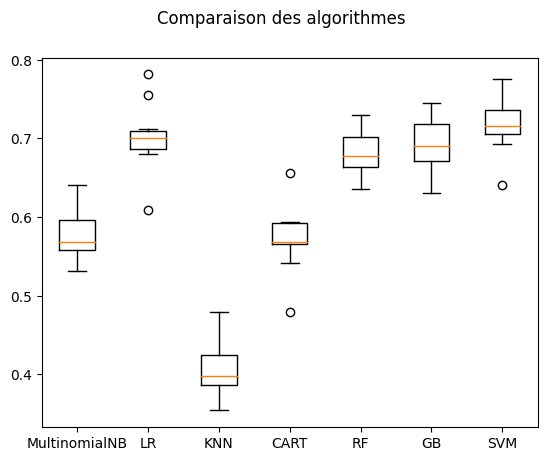

In [141]:
MyTestPipelines(models,X2_equi_sm,y2_equi_sm,'accuracy')

Accuracy : 0.558
Classification Report
              precision    recall  f1-score   support

           0    0.59108   0.90341   0.71461       176
           1    0.52632   0.25641   0.34483        78
           2    0.00000   0.00000   0.00000        25
           3    0.36842   0.20896   0.26667        67

    accuracy                        0.55780       346
   macro avg    0.37145   0.34219   0.33153       346
weighted avg    0.49065   0.55780   0.49287       346



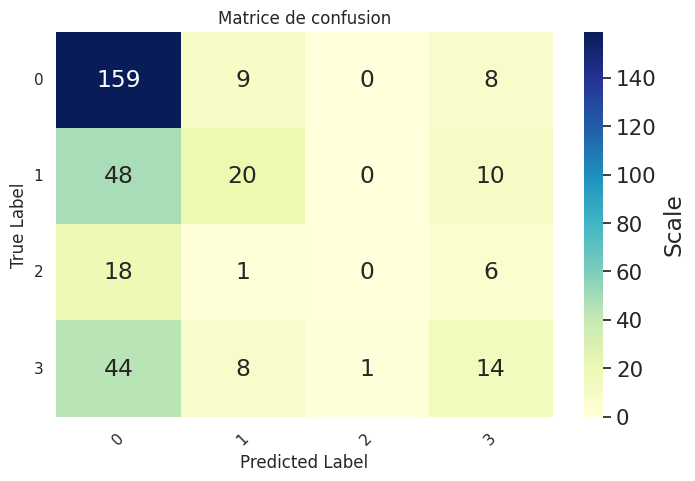

In [157]:
model.fit(X2_equi_sm, y2_equi_sm)
y2_pred_sm = model.predict(X2_test)
MyshowAllScores(y2_test,y2_pred_sm)

# Remaquons le f1-score de la classe 2 est nul (c'est pas bien)

> **-7 Optimisation des modèles avec les hyperparamètres**

*Modèle SVM*

In [ ]:
model.get_params()

*Modèle LogisticRegression*

In [ ]:
model2.get_params()

*Modèle RandomForestClassifier*